# Descriptive Data Analysis

1. How many articles there are, how many paths
2. Histograms of the links from each article (for example, how many articles have 20 links, etc)
3. Average distance from one article to any other article
4. Histogram of the number of games at each point in time
5. Categories of targets in unfinished games
6. Classify how many times each word appears in the games (we could also do a histogram with that)

In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
wikispeedia= nx.read_edgelist('datasets/wikispeedia_paths-and-graph/links.tsv', 
                                    create_using=nx.DiGraph)
paths_finished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows=15, 
                   names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "rating"])
paths_unfinished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', skiprows=16,
                               names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "target", "type"])

## 1. How many: articles, links, finished games, unfinished games?

In [11]:
print("There are", len(wikispeedia.nodes), "articles in the dataset.")
print("There are", len(wikispeedia.edges), "links/paths.")
print("There are", paths_finished.shape[0], "finished games.")
print("There are", paths_unfinished.shape[0], "unfinished games.")

There are 4592 articles in the dataset.
There are 119882 links/paths.
There are 51318 finished games.
There are 24875 unfinished games.


In [27]:
unique_paths = paths_finished['path'].unique()
print('There are', len(unique_paths), 'unique finshed paths.')

There are 47856 unique paths.


## 2. Degree of a Node
The degree of a node is the number of edges/links it has. We plot a complementary cumulative distribution function (CCDF) of degree for each article/node.

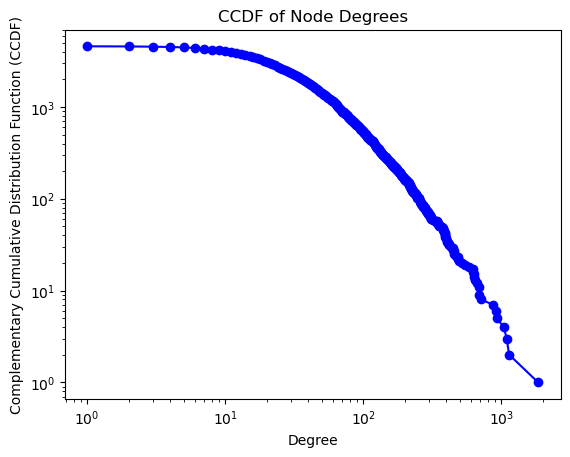

In [12]:
# Get the degrees of all nodes
degrees = dict(wikispeedia.degree())

# Calculate the CCDF
degree_values = sorted(set(degrees.values()), reverse=True)
ccdf = [sum(1 for degree in degrees.values() if degree >= d) for d in degree_values]

# Plot the CCDF
plt.plot(degree_values, ccdf, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
plt.title('CCDF of Node Degrees')
plt.show()

What are the "hubs"? Which nodes have more than 500 links?

In [13]:
print("Nodes with more than 1000 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 1000])
print("Nodes with more than 500 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 500])


Nodes with more than 1000 edges:  ['United_Kingdom', 'France', 'United_States', 'Europe']
Nodes with more than 500 edges:  ['Russia', 'United_Kingdom', 'World_War_II', 'France', 'Germany', 'Italy', 'Canada', 'English_language', 'England', 'Spain', 'United_States', 'India', 'China', 'Europe', 'Australia', 'Japan', 'London', 'Africa', 'Animal', 'Scientific_classification']


Observe that biggest hubs are mainly countries. The 'United Kingdom', 'France', 'United States', and 'Europe' have over 1000 links. Since there are 4592 nodes, these nodes have link to almost 1/4 of the dataset!

How many nodes have more than 20 links? How many have only 1 link?

In [14]:
# Count the number of nodes with degree 1
nodes_degree_1 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) == 1]
print('Nodes with degree 1: ', nodes_degree_1)

# Get the percentages
total_nodes = len(wikispeedia.nodes)
percentage_degree_1 = (len(nodes_degree_1) / total_nodes)
print('% of nodes that have only 1 edge/link:', percentage_degree_1)

# Count number of nodes with degree <= 20
nodes_degree_20 = sum(1 for degree in degrees.values() if degree <= 20)
print('% of nodes that have 20 or less edges/links:', nodes_degree_20 / total_nodes)

Nodes with degree 1:  ['All_your_base_are_belong_to_us', 'Local_community', 'Dewey_Square', 'Emma_Roberts', 'Human_abdomen', 'Pere_Marquette_1225', 'Pro_Milone', 'Sunol_Water_Temple', 'T._D._Judah', 'Terik', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'White_Mountain_art']
% of nodes that have only 1 edge/link: 0.0028310104529616726
% of nodes that have 20 or less edges/links: 0.344294425087108


## 3. Average Distance between Articles
On average, how many links/edges does it take to connect any random two articles?

In [15]:
# Our graph is not strongly connected, meaning it's not possible to reach every node from every other node
# So we can't use the built in function nx.average_shortest_path_length

# This takes a long time to run (30 sec)
# shortest_paths = list(nx.all_pairs_shortest_path_length(wikispeedia))
# reachable_pairs = [(source, target, length) for source, paths in shortest_paths for target, length in paths.items() if length != float('inf')]
# total_distances = sum(length for _, _, length in reachable_pairs)
# average_distance = total_distances / len(reachable_pairs) if reachable_pairs else 0
# print(f"Average distance between reachable nodes: {average_distance:.2f}")


## 4. Games per Time
Histogram of the number of games at each point in time.


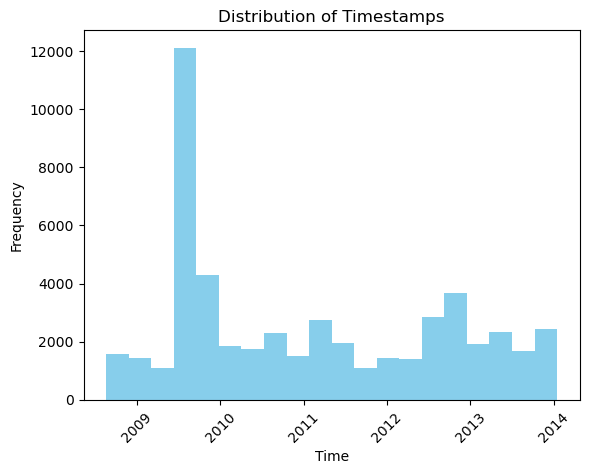

In [16]:
# Convert timestamps to datetime objects
timestamps = paths_finished['timestamp']
date_times = [datetime.utcfromtimestamp(ts) for ts in timestamps]

# Create a histogram of timestamps
plt.hist(date_times, bins=20, color='skyblue')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

A lot of games were played in Q3 2009! 

In [17]:
q3_2009_times = [dt for dt in date_times if dt.year == 2009 and dt.month in [7, 8, 9]]
percent_q3_2009_times = len(q3_2009_times) / len(date_times)
print(f"Percent of finished games completed in Q3 2009: {percent_q3_2009_times:.2f}")


Percent of finished games completed in Q3 2009: 0.24


## 5. Which categories of games are more likely to be unfinished? 

In [ ]:
categories = pd.read_csv('datasets/wikispeedia_paths-and-graph/categories.tsv', sep='\t', skiprows=12, names = ['article', 'categories'])
categories[categories['article'].duplicated()]
print('There are', categories['article'].duplicated().sum(), 'articles with more than 1 category.')

print('Should we drop the duplicate categories, or doublecount them?')
print('This corresponds to', categories['article'].duplicated().sum() / len(wikispeedia.nodes), 'of the articles.')

# Let's drop them for now.
categories['article'] = categories['article'].drop_duplicates()
categories.shape

# Why are there more articles here than nodes (# articles)?

There are 606 articles with more than 1 category.
Should we drop the duplicate categories, or doublecount them?
This corresponds to 0.13196864111498258 of the articles.


(5204, 2)

In [61]:
sub_categories = categories['categories'].str[8:].str.split('.')
category_depth_1 = sub_categories.apply(lambda x: x[0])
categories['depth_1'] = category_depth_1
categories.head()

,article,categories,depth_1
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures,People
2,%C3%85land,subject.Countries,Countries
3,%C3%85land,subject.Geography.European_Geography.European_...,Geography
4,%C3%89douard_Manet,subject.People.Artists,People


In [63]:
paths_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


In [62]:
# Let's find the category corresponding to each unfinished target
pd.merge(paths_unfinished, categories, left_on = 'target', right_on= 'article', how = 'left')

,hashedIpAddress,timestamp,durationInSec,path,target,type,article,categories,depth_1
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,Microsoft,subject.Business_Studies.Companies,Business_Studies
1,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,Microsoft,subject.IT.Software,IT
2,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,Caracas,subject.Geography.Central_and_South_American_G...,Geography
3,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,First_Crusade,subject.History.Pre_1900_Military,History
4,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,First_Crusade,subject.Religion.Religious_disputes,Religion
...,...,...,...,...,...,...,...,...,...
29180,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart,Cholera,subject.Science.Biology.Health_and_medicine,Science
29181,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart,Hollandic,subject.Language_and_literature.Languages,Language_and_literature
29182,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout,The_Beatles,subject.Music.Performers_and_composers,Music
29183,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout,Alan_Turing,subject.People.Mathematicians,People
